<a href="https://colab.research.google.com/github/MikeSalnikov/ML_for_business/blob/main/HW5_ml_in_business_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [3]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [9]:
from sklearn.preprocessing import StandardScaler

final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler()) # не забыл добавить стандартизацию - нормирование вещественных признаков
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [10]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

#### 1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков). 
#### 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика).
#### 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.
#### 4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3.
#### 5. (опционально) Еще раз провести оценку экономической эффективности.

1 - GradientBoostingClassifier

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state=42)),
])

In [12]:
# обучу пайплайн:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [13]:
# прогнозы для тестовой выборки:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.28502357, 0.22926788, 0.1982218 , 0.08930468, 0.04798288,
       0.80662596, 0.03834531, 0.05054472, 0.31038377, 0.73455865])

In [14]:
# метрики:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.4085078904556646, F-Score=0.646, Precision=0.704, Recall=0.597


In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


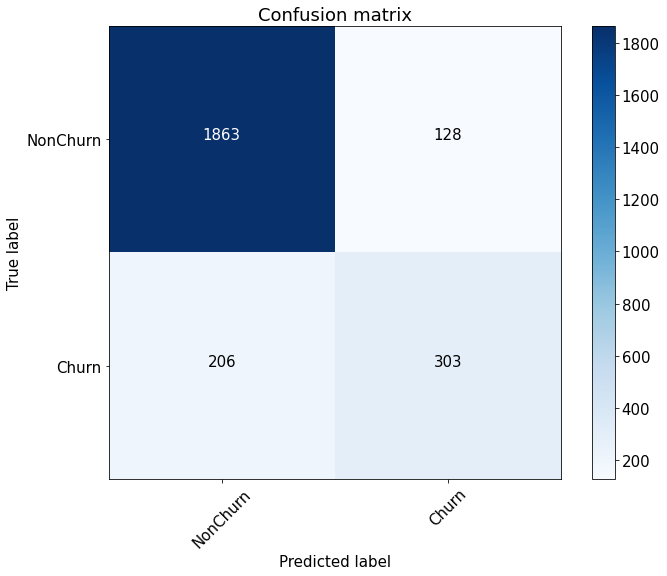

In [16]:
# уже нашел ранее "оптимальный" порог, когда максимизировал f_score:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [17]:
# считаю экономическую целесообразность:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]


retain_sum = (FP + TP) * 1
income = TP * 2

profit_gb = income - retain_sum
print(f"Прибыль для модели {type(pipeline['classifier']).__name__} без подбора параметров: {profit_gb}")

Прибыль для модели GradientBoostingClassifier без подбора параметров: 175


In [18]:
# создаю датафрейм для метрик:
metrics_df = pd.DataFrame(columns=['model', 'thresh', 'F-Score', 'Precision', 'Recall', 'ROC AUC'])

In [19]:
# считаю ROC AUC:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.8757458662211781

In [20]:
# добавляю в датафрейм с метриками данные по модели GradientBoostingClassifier без подбора параметров:
metrics_df = metrics_df.append({
    'model': type(pipeline['classifier']).__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC
0,GradientBoostingClassifier,0.408508,0.646121,0.703704,0.59725,0.875746


In [ ]:
# # варианты параметров для их подбора в GridSearchCV:
# params = {'classifier__max_features': [0.3, 0.7, 10],
#           'classifier__max_depth': [4, 8, 12],
#           'classifier__min_samples_leaf': [0.1, 2, 5],
#           'classifier__n_estimators': [100, 150, 300]
#           }

In [ ]:
# %%time

# # определяю лучшие параметры:

# grid = GridSearchCV(pipeline,
#                     param_grid=params,
#                     cv=6,
#                     refit=False)

# search = grid.fit(X_train, y_train)
# search.best_params_

In [ ]:
# search.best_params_

На подбор параметров ушла 31 минута и 13 секунд. 
Лучшими были определены: 
{'classifier__max_depth': 4,
 'classifier__max_features': 0.7,
 'classifier__min_samples_leaf': 5,
 'classifier__n_estimators': 100}

Их и использую дальше: 

In [21]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(max_depth=4, 
                                              max_features=0.7, 
                                              min_samples_leaf=5, 
                                              n_estimators=100, 
                                              random_state=42)),
])

In [22]:
# обучу пайплайн (после подбора параметров):
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [23]:
# прогнозы для тестовой выборки (после подбора параметров):
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.24914939, 0.21000481, 0.17948553, 0.06947836, 0.03050923,
       0.80099202, 0.04682162, 0.05704286, 0.22983397, 0.84692434])

In [24]:
# метрики (после подбора параметров):
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.4170581098037875, F-Score=0.639, Precision=0.684, Recall=0.599


Confusion matrix, without normalization
[[1850  141]
 [ 205  304]]


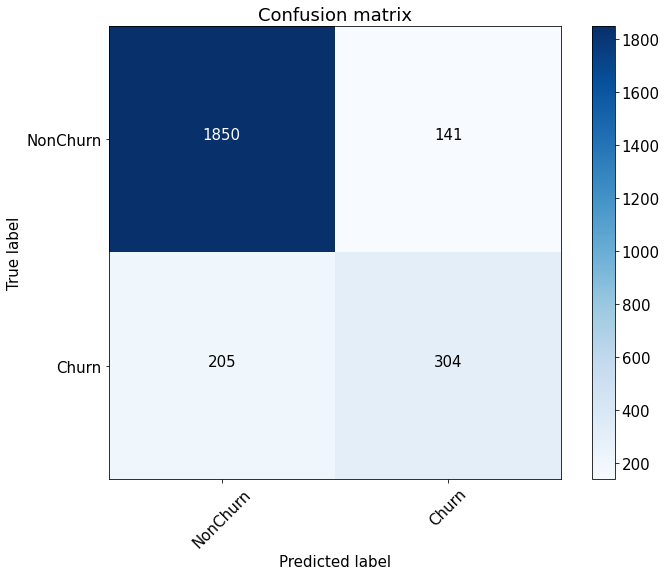

In [25]:
# уже нашел ранее "оптимальный" порог, когда максимизировал f_score (после подбора параметров):
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [26]:
# снова делаю оценку экономической эффективности (после подбора параметров): 
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]


retain_sum = (FP + TP) * 1
income = TP * 2

profit_gb_gs = income - retain_sum
print(f"Прибыль для модели {type(pipeline['classifier']).__name__} с подбором параметров: {profit_gb_gs}")

Прибыль для модели GradientBoostingClassifier с подбором параметров: 163


In [27]:
profit_gb_gs > profit_gb

False

Вывод: после подбора параметров результаты работы модели GradientBoostingClassifier ухудшились - "прибыль" упала.

In [28]:
# считаю ROC AUC (после подбора параметров):
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.8745439941426003

In [29]:
# добавляю в датафрейм с метриками данные по модели GradientBoostingClassifier с подбором параметров:
metrics_df = metrics_df.append({
    'model': type(pipeline['classifier']).__name__ + ' + GS',
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC
0,GradientBoostingClassifier,0.408508,0.646121,0.703704,0.597250,0.875746
1,GradientBoostingClassifier + GS,0.417058,0.638743,0.683857,0.599214,0.874544


Вывод: подбор параметров практически не улучшил модель GradientBoostingClassifier. 

2 - LogisticRegression

In [30]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state=42)),
])

In [31]:
# обучу пайплайн:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [32]:
# прогнозы для тестовой выборки:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

In [33]:
# метрики:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.289521955216512, F-Score=0.510, Precision=0.462, Recall=0.568


Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


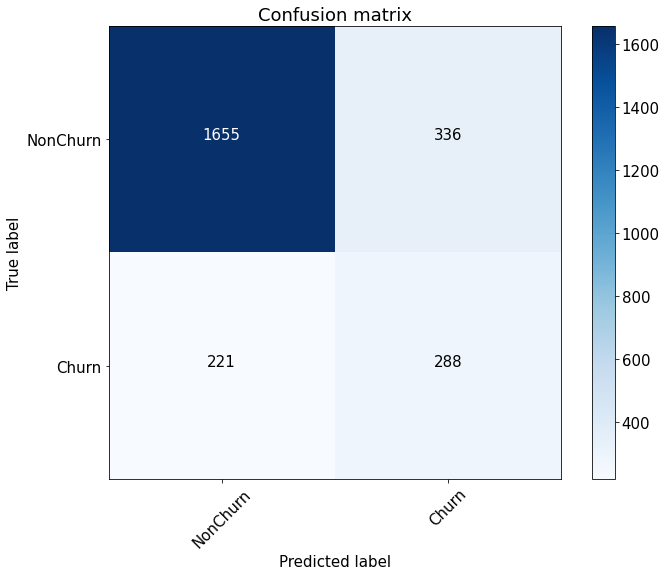

In [34]:
# уже нашел ранее "оптимальный" порог, когда максимизировал f_score:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [35]:
# считаю экономическую целесообразность:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]


retain_sum = (FP + TP) * 1
income = TP * 2

profit_lr = income - retain_sum
print(f"Прибыль для модели {type(pipeline['classifier']).__name__}: {profit_lr}")

Прибыль для модели LogisticRegression: -48


Таким образом модель LogisticRegression работает в убыток! 

In [36]:
# считаю ROC AUC:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.7720774921330664

In [37]:
# добавляю в датафрейм с метриками данные по модели GradientBoostingClassifier без подбора параметров:
metrics_df = metrics_df.append({
    'model': type(pipeline['classifier']).__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC
0,GradientBoostingClassifier,0.408508,0.646121,0.703704,0.597250,0.875746
1,GradientBoostingClassifier + GS,0.417058,0.638743,0.683857,0.599214,0.874544
2,LogisticRegression,0.289522,0.509700,0.462400,0.567780,0.772077


ВЫВОД: лучшая модель по метрикам - GradientBoostingClassifier (без подбора параметров). 

Наиболее подходящая метрика для оценки оттока - это f1-score. Так как нам нужно максимально определить людей, ушедших в отток, то нужно максимизировать recall. Но также нельзя забывать, что привлечение стоит денег. Поэтому для максимизации прибыли нужно минимизировать FP, то есть максимизировать precision. И именно при f1-score находится баланс между precision и recall.